### Kernelized Supervised Laplacian Eigenmap of Multi-Label Data
This python code is an implementation of Kernelized Supervised Laplacian Eigenmap\\for Visualization and Classification of Multi-Label Data published in Pattern Recognition journal.

First, let's prepare necessary libralies. 

In [1]:
from matplotlib import pyplot as plt
from matplotlib import offsetbox
import numpy as np
import sys
import math
import scipy.linalg
from numpy import linalg as LA
from sklearn.metrics import pairwise

from scipy import sparse
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh, lobpcg
from scipy.sparse.csgraph import connected_components

from sklearn import datasets
from sklearn.utils import check_random_state, check_array, check_symmetric
from sklearn.base import BaseEstimator
from sklearn.utils.extmath import _deterministic_vector_sign_flip
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestCentroid

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding

from scipy.sparse import csr_matrix, isspmatrix
from matplotlib.colors import LinearSegmentedColormap    #
import matplotlib #
import random
from sklearn.metrics import classification_report, accuracy_score

import np_utils
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.datasets import mnist


The following is main body.

In [2]:
class KSLE_ML():
    def __init__(self, n_components=2, affinity="nearest_neighbors",
                 gamma=None, random_state=None, eigen_solver=None,
                 n_neighbors=None, kernel=None, kopt1=None, n_jobs=1, la=0.5, t=1.0):
        self.n_components = n_components
        self.affinity = affinity
        self.gamma = gamma
        self.random_state = random_state
        self.eigen_solver = eigen_solver
        self.n_neighbors = n_neighbors
        print(n_neighbors)
        self.n_jobs = n_jobs
        self.la = la
        self.t = t
        # Kernel selection with option
        self.kernel = kernel
        self.kopt1 = kopt1

    @property
    def _pairwise(self):
        return self.affinity == "precomputed"

    def change_kernel(self, kernel, kopt1=None, setonly =False):
        self.kernel = kernel
        self.kopt1 = kopt1
        ans = True
        if setonly == False:
            G = self._calc_kernel(self.X, self.X)
            self.G = G
            '''
            Ginv,rank = scipy.linalg.pinv(G,return_rank=True)   # Moore-penrose generalized inverse
            print('*Recalc of G* Size of G is '+ str(G.shape) +' rank is ' + str(rank))
            self.C = np.dot(Ginv, self.Z)     # Recalculate coefficent of kernel mapping
            '''
            # Solve linear equation GC = Z instead of C = G^{-1}Z (Mine)
            rank = np.linalg.matrix_rank(G)
            print('Rank of G is '+str(rank))

            try:
                self.C = np.linalg.solve(G, self.Z)
            except np.linalg.LinAlgError as e:
                if 'Singular matrix' in str(e):
                        exit()
            ans = (rank==self.X.shape[0])
            print('(change)self.C.shape = '+str(self.C.shape)+' rank test='+str(ans))
        return ans

    def _calc_kernel(self, X, Y=None):
        print('Used kernel = ' + self.kernel + " w opt1 = "+ str(self.kopt1))
        if self.kernel == "polynomial":
            k  = pairwise.polynomial_kernel(X, Y, degree=self.kopt1)
        elif self.kernel == "rbf":
            k  = pairwise.rbf_kernel(X, Y, gamma=self.kopt1)
        elif self.kernel == "sinc":
            k  = sinc_kernel(X, Y, alpha=self.kopt1)

        if X.shape == Y.shape:
            print ('Gram matrix was (re)calculated.')
            self.G = k
        return k

    def explicit_map(self,Y):
        C = self.C                                                 # coefficients of kernels
        print('(exp)self.C.shape = '+str(self.C.shape))
        k = self._calc_kernel(self.X,Y)           # innerproduct to the training sample via kernel
        Z =  np.dot(C.T,k)
        print('(exp) Z.shape = '+str(Z.shape)+' C= '+str(C.shape)+' k= '+str(k.shape))
        return  Z

    def _get_affinity_matrix(self, X, Y=None):
        self.X = X
        print('=== self.X was set in get_affinity')
        length=X.shape[0]
        la = self.la
        t = self.t
        n = self.n_neighbors
        dist = np.zeros(length*length).reshape((length,length))

        print('In n_nearest: n=%d t=%f la=%f len=%d' % (n, t, la, length))

        N = np.zeros(length*length).reshape((length,length))
        nn = NearestNeighbors(n_neighbors=n+1)
        nn.fit(X)
        distances, indices = nn.kneighbors(X)
        self.distances = distances
        self.indices = indices

        #print('distance')
        #print(distances[0:5,:])
        #print('indices')
        #print(indices[0:5,:])

        for i in range(length):
            for j in indices[i][1:n]:  # indices[i][0]=i itself
                N[i][j] = 1            # 1 if j is i's one of k NN's

        w_F = weight = (N + N.T)*0.5 #return 0,1 or 0.5

        for i in range(length):
            for j in range(length):

                A = len(np.intersect1d(Y[i],Y[j])) #$B@Q=89g(B
                B = len(np.union1d(Y[i],Y[j])) #$BOB=89g(B
                w_L = float(A)/float(B)
                weight[i][j] = la*w_F[i][j] + (1-la)*w_L
                if i==j:
                    weight[i][j]=0.0

        self.affinity_matrix_ = weight
        return self.affinity_matrix_


    def get_parameter(self):
        distances = self.distances
        indices = self.indices
        n = self.X

        print('k = ' + str(self.n_neighbors))
        print('n = ' + str(self.X.shape[0]))

        k = np.sum (np.sum(np.power(distances,2), axis=1)/self.n_neighbors) / self.X.shape[0]
        print('alpha = ' + str(k))
        return k



    def fit(self, X, y=None):
        W = self._get_affinity_matrix(X,y)                 # W: similarity matrix
        W_col_sum = np.sum(W, axis=1)
        n = X.shape[0]    # number of samples

        Dmhalf = np.zeros(n*n).reshape((n,n))
        for i in range(n):
            Dmhalf[i][i] = 1.0/np.sqrt(W_col_sum[i])  # D^-1/2
        np.savetxt('Dhalf.csv', Dmhalf, delimiter=',')

        DW = np.dot(Dmhalf,W)
        DWD = np.dot(DW,Dmhalf)                                   # D^{-1/2}WD^{-1/2}
        np.savetxt('DWD.csv', DWD, delimiter=',')

        Lambda,U = scipy.linalg.eigh(DWD,eigvals=(n-3,n-1))  # Spectral Decomposition

        print('eigen decomposition')
        print(U)
        print('Shape - Lambda ' + str(Lambda.shape) + ' U ' + str(U.shape))

        Lambda = Lambda[::-1]   # Choose from the largest eigenvalues except for the largest
        print(Lambda)
        U = U[:,::-1]
        print(U)
        sq_U = np.dot(U.T,U)
        print(sq_U)

        DU = np.dot(Dmhalf,U)
        Z = DU                                   # mapped points

        print('eigen_vector')
        print(Z)

        Z=Z[:,1:3]

        # direction alightment of eigen vectors w.r.t. class 0
        clz_index = (y==0)
        clz_size = np.sum(clz_index)
        valid_index = np.vstack((clz_index,clz_index))
        valid_index =  valid_index.T
        Xz = Z[valid_index]
        Xz = Xz.reshape(clz_size,2)
        Xsum = np.sum(Xz,axis=0)
        Strans = np.identity(2)
        if Xsum[0] < 0:
            Strans[0,0]=-1
        if Xsum[1] < 0:
            Strans[1,1]=-1
        print(Strans)
        Z = np.dot(Z,Strans)

        self.Z = Z
        self.embedding = Z.T
        return self


    def fit_transform(self, X, y=None):
        self.fit(X,y)
        return self.embedding

    def return_C(self):
        C = self.C
        return C


Sinc kernel is made ready in case. Default is RBF kernel.

In [3]:
def sinc_kernel(X,Y,alpha=1.0):             # sin(\alpha \|X-Y\|)/(pi \alpha \|X-Y\|)
    nx = X.shape[0]
    mx = X.shape[1]
    ny = Y.shape[0]
    my = Y.shape[1]
    print('(Sigmoid-Kernel ) nx ='+str(nx)+' mx='+str(mx)+' ny='+str(ny)+' my='+str(my)+' alpha='+str(alpha))
    if mx != my:
        print('nx ='+str(nx)+' mx='+str(mx)+' ny='+str(ny)+' my='+str(my))
        exit
    A = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            nxy = np.linalg.norm(X[i,:]-Y[j,:])

            if nxy == 0.0:
                ans = 1.0/math.pi
            else:
                ans = math.sin(alpha*nxy)/(math.pi*alpha*nxy)
            A[i,j]=ans
    return A


Below is for setting a color map.

In [4]:
def generate_cmap(colors):

    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

In [5]:
def SLE(X,Y, gamma=100, sigma=0.1, la=0.3): # defaul value of lambdais 0.3 to 0.4

    n_classes = len(np.unique(Y))
    n_samples = X.shape[0]
    print("n_classes:",n_classes, "n_samples:",n_samples)
    n_neighbors = int(1.5*n_samples/n_classes)   # 1.5 times of average sample number / class

    manifolder = KSLE_ML(n_neighbors=n_neighbors, la=la, t=1.0/gamma, kernel="rbf")

    # Supervised Laplacian Eigenmap -> Find the mapped points
    X_transformed = manifolder.fit_transform(X,Y) 
    
    return X_transformed, manifolder

def KSLE(X,manifolder, name):        # realize SLE by a kernel and map testing samples
    # mean variance using k-NN of each data in the original space
    kernel_parameter = 1. / manifolder.get_parameter()
    opt = 1.0 * kernel_parameter
    f=manifolder.change_kernel(name,opt) 
    X_transformed = manifolder.explicit_map(X) 
    
    return X_transformed

In [6]:
def dataset():
    ####Iris
    '''
    d_name = "Iris"
    X = np.loadtxt('iris.data',dtype='float')
    n_samples, n_features = X.shape
    z = np.arange(n_samples)
    z[0:50]=0
    z[50:100]=1
    z[100:150]=2
    y = list(range(n_samples))
    y = z
    n_neighbors = 75
    n_class = 3
    d_name = "Iris"
    '''

    ####digit
    d_name = "Digit"
    
    dataset = datasets.load_digits()
    X = dataset.data
    y = dataset.target
    n_samples, n_features = X.shape
    n_class = 10


    n_sel_samples = 500                             # define a smaller number of samples if you need
    # sample selection
    random.seed(0)
    id_all = np.random.choice(n_samples,n_samples,replace=False)
    id_train = id_all[0:n_sel_samples]
    id_test  = id_all[n_sel_samples:]

    #print("id_train:",id_train)
    #print("id_test:",id_test)

    X_train = X[id_train]
    Y_train = y[id_train]
    X_test = X[id_test]
    Y_test = y[id_test]
    
    n_samples, n_features = X_train.shape
    print("#training=",X_train.shape[0]," #testing=",X_test.shape[0]," Dimensionality=",n_features)
    return X_train, Y_train, X_test, Y_test
    


Last let's display the mapped training and testing data.

In [7]:
def two_d_display(Z,Y,ssize=25,smark="o"):
    
    fig, ax = plt.subplots(figsize=(10,10))
    
#    plt.xlim(xdmin[0],xdmax[0])          
#    plt.ylim(xdmin[1],xdmax[1])

    n_classes = len(np.unique(Y))
    
    if n_classes == 2:
        cm = generate_cmap(['blue','red'])
    elif n_classes == 3:
        cm = generate_cmap(['orange','green','red'])
    elif n_classes == 10:
        cm = generate_cmap(['mediumblue','aqua','orange','black','red','yellow','purple','pink','green','grey'])

    plt.scatter(Z[0,:], Z[1,:], s=ssize, marker=smark, c=Y, cmap=cm, edgecolors="black") 

    plt.show()

OK. Everything is ready. Try below.

#training= 500  #testing= 1297  Dimensionality= 64
n_classes: 10 n_samples: 500
75
=== self.X was set in get_affinity
In n_nearest: n=75 t=0.010000 la=0.300000 len=500
eigen decomposition
[[ 0.01816794 -0.096852    0.0457686 ]
 [ 0.01474226 -0.09330659  0.04483445]
 [ 0.05221553 -0.05335085  0.04112148]
 ...
 [-0.01020169  0.01365548  0.04802455]
 [-0.03728263  0.03842253  0.04809793]
 [-0.04572527  0.02138797  0.04371939]]
Shape - Lambda (3,) U (500, 3)
[1.         0.90341757 0.87398379]
[[ 0.0457686  -0.096852    0.01816794]
 [ 0.04483445 -0.09330659  0.01474226]
 [ 0.04112148 -0.05335085  0.05221553]
 ...
 [ 0.04802455  0.01365548 -0.01020169]
 [ 0.04809793  0.03842253 -0.03728263]
 [ 0.04371939  0.02138797 -0.04572527]]
[[1.00000000e+00 6.24500451e-17 1.66533454e-16]
 [6.24500451e-17 1.00000000e+00 1.83880688e-16]
 [1.66533454e-16 1.83880688e-16 1.00000000e+00]]
eigen_vector
[[ 0.00593847 -0.01256653  0.00235729]
 [ 0.00593847 -0.01235876  0.00195266]
 [ 0.00593847 -0.00770455  0.0

(change)self.C.shape = (500, 2) rank test=True
(exp)self.C.shape = (500, 2)
Used kernel = rbf w opt1 = 0.0007963026077317798
(exp) Z.shape = (2, 1297) C= (500, 2) k= (500, 1297)
Transformed testing data size (2, 1297)
Transformed testing data
 [[-0.00203679 -0.0013096  -0.00622731 ... -0.00327752  0.0127007
  -0.00422378]
 [-0.00180027  0.0063144  -0.00053421 ... -0.01171474 -0.00220369
   0.00256293]]


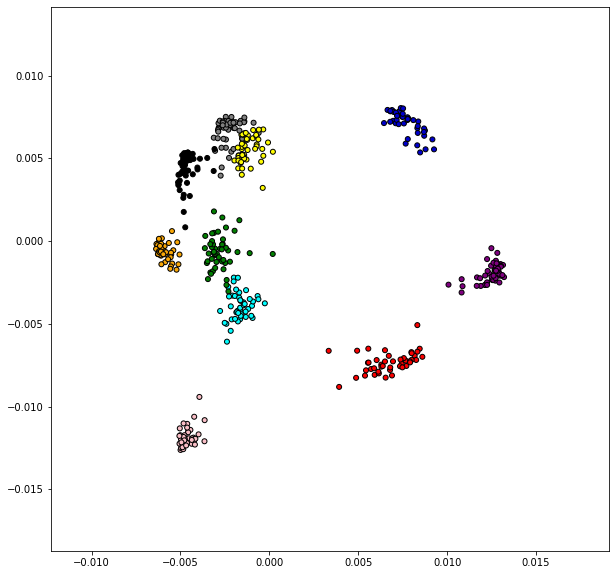

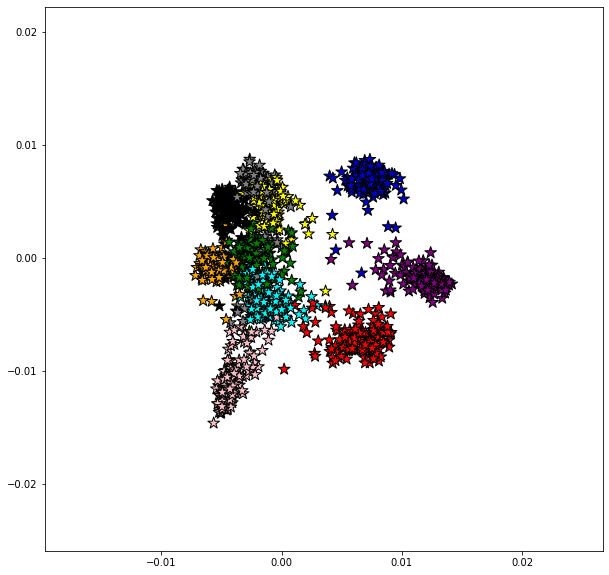

In [8]:
X_train,Y_train,X_test,Y_test =dataset()
Z_train,manifolder= SLE(X_train,Y_train)
print("Transformed training data size",Z_train.shape)
print("Transformed training data\n",Z_train)

Z_test=KSLE(X_test,manifolder, "rbf")
print("Transformed testing data size",Z_test.shape)
print("Transformed testing data\n",Z_test)

two_d_display(Z_train,Y_train)
two_d_display(Z_test,Y_test,ssize=150,smark="*")

(Option) Last, let's think to classify testing samples in the mapped space. Here, we use a nearst centroid classifier.

In [15]:
def NCC_assifier(Z_tr, Y_tr, Z_te, Y_te):
        #Nearest Centroid Classifier appliced in the mapped space
        test = Z_te.T
        train = Z_tr.T
        print(test)
        print("Training:",train.shape)
        print("Testing :",test.shape)
        n_classes = len(np.unique(Y_tr))
        print("#classes:",n_classes)
        
        CLF = np.arange(n_classes+1,dtype=float)
        CLF[10] = 0.0

        #Nearest Centroid Classifier
        print("-Nearest Centroid Classifier-")
        clf = NearestCentroid()
        clf.fit(train, Y_tr)
        y_pred = np.copy(clf.predict(test))

        TorF = np.zeros(test.shape[0])
        for n in range(test.shape[0]):
            if Y_te[n] == y_pred[n]:
                TorF[n] = 1
        TorF_sum = np.sum(TorF,dtype=float)
        print("TorF:",TorF)
        CCLF = np.copy(float(TorF_sum)/float(test.shape[0]))

        CLF[0] = np.copy(accuracy_score(Y_test, y_pred))
        print('accuracy_score = '+ str(CLF[0]))
        print('CLF = ' + str(CCLF))


In [16]:
NCC_assifier(Z_train,Y_train,Z_test,Y_test)

[[-0.00203679 -0.00180027]
 [-0.0013096   0.0063144 ]
 [-0.00622731 -0.00053421]
 ...
 [-0.00327752 -0.01171474]
 [ 0.0127007  -0.00220369]
 [-0.00422378  0.00256293]]
Training: (500, 2)
Testing : (1297, 2)
#classes: 10
-Nearest Centroid Classifier-
TorF: [1. 0. 1. ... 1. 1. 1.]
accuracy_score = 0.8596761757902853
CLF = 0.8596761757902853
